## Data Analysis

#### Importing required packages

In [1]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pymongo as pm
import numpy as np
import warnings
import math

warnings.filterwarnings("ignore")
plt.style.use('seaborn')

In [2]:
@ticker.FuncFormatter
def million_formatter(x, pos):
    return "%.1f M" % (x/1E6)

font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':15}

### Connecting to mongoDB using PyMongo

In [3]:
client = pm.MongoClient("mongodb://127.0.0.1:27017/?directConnection=true&serverSelectionTimeoutMS=2000&appName=mongosh+1.6.0")
db = client['project']
col = db['vaccinations']

# Analysis - 1

## Plotting total vaccination count of each countries

Australia = 56242913.0
England = 118170701.0
Austria = 18131115.0
Argentina = 96504666.0
Hong Kong = 14944464.0


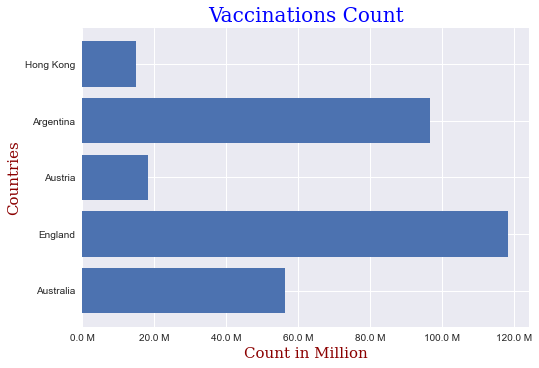

In [4]:
input_country = ['Austria','Hong Kong','England','Argentina','Australia'] 

total_vaccinations = [ list(i.values()) 
                      for i in col.aggregate([
                          {'$match' : {'country' : {'$in' : input_country}}},
                          {'$group':{'_id': "$country",'Total' : { '$max':'$total_vaccinations'}}}                        
                      ])]

country_list = list(map(lambda x:x[0],total_vaccinations))

total_vaccinations_count = list(map(lambda x:x[1],total_vaccinations))

fig, ax = plt.subplots()

ax.barh(country_list,total_vaccinations_count)

ax.xaxis.set_major_formatter(million_formatter)

plt.title("Vaccinations Count", fontdict = font1)
plt.xlabel("Count in Million", fontdict = font2)
plt.ylabel('Countries', fontdict = font2)

for i in range(len(country_list)):
    
    print(country_list[i],"=",total_vaccinations_count[i])

# Analysis - 2

## Plotting daily vaccination details for each countries

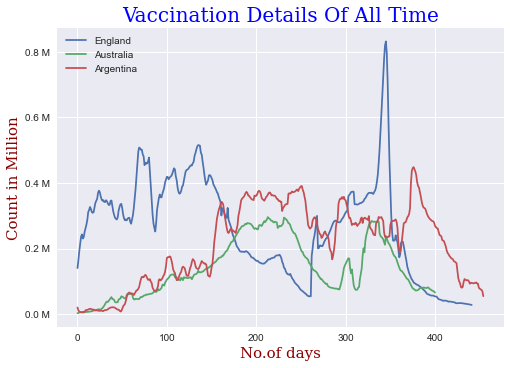

In [5]:
input_country = ["England",'Australia','Argentina']

cd = []

for j in input_country:
    country_daily = [list(i.values()) 
                     for i in col.find(
                    {'country':j,'daily_vaccinations':{ '$exists': 'true', '$ne': 'null' }},
                    {'_id':0,'daily_vaccinations':1,'date':1})]
    
    cd.append(list(map(lambda x:x[1],country_daily)))

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(million_formatter)

for i in range(len(input_country)):
    ax.plot(cd[i],label=input_country[i])

plt.title("Vaccination Details Of All Time", fontdict = font1)
plt.xlabel("No.of days", fontdict = font2)
plt.ylabel("Count in Million", fontdict = font2)

ax.legend(loc='upper left')

# Analysis - 3
## Plotting total number of countries used a particular kind of vaccine

Text(0, 0.5, 'No.of Countries Used')

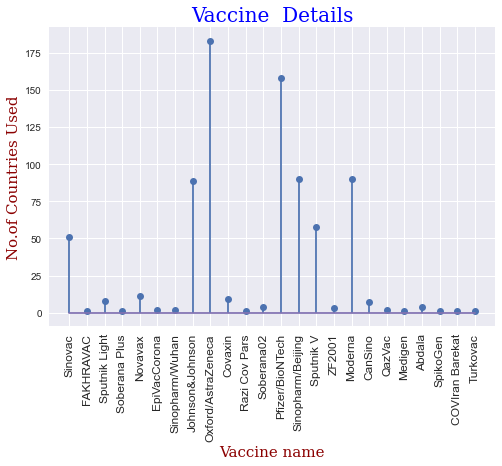

In [6]:
#Fetching all vaccine anmes
temp_v1 = list(col.find({}, {'vaccines':1, '_id':0}))
temp_v2 = [str(i['vaccines']).split(',') for i in temp_v1]
vaccines = []
for i in temp_v2:
    vaccines.extend(i)
    
vaccines = list(set([i.strip() for i in vaccines]))


#Collecting the count of countires for a particular vaccine
country_count= []
for i in vaccines:
    country_count.append(len(col.distinct( "country", {'vaccines' : {'$regex' : i}}  )))
    
fig, ax = plt.subplots() 
ax.stem(vaccines, country_count, use_line_collection = True)
ax.set_xticklabels(vaccines, rotation='vertical', fontsize=12)


plt.title("Vaccine  Details", fontdict = font1)
plt.xlabel("Vaccine name", fontdict = font2)
plt.ylabel("No.of Countries Used", fontdict = font2)

# Analysis 4
### Plotting Fully vs Partially Vaccinated People ( 1<= country count <= 5)

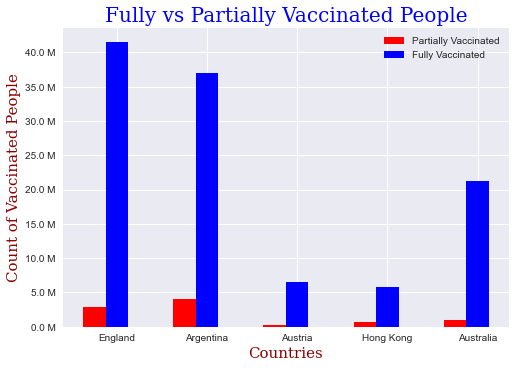

In [7]:
input_country = ['Austria','Hong Kong','England','Argentina','Australia']

total_vaccinations = [ list(i.values()) 
                      for i in col.aggregate([
                          {'$match' : {'country' : {'$in' : input_country}}},
                          {'$group':{'_id': "$country",'Totalp' : { '$max':'$people_vaccinated'},'Totalf' : { '$max':'$people_fully_vaccinated'}}}                        
                      ])]

people_partially_vaccinated = list(map(lambda x:abs(x[2] - x[1]), total_vaccinations))
people_fully_vaccinated = list(map(lambda x:x[2], total_vaccinations))
countries = list(map(lambda x:x[0], total_vaccinations))

#plotting

N = len(countries)
ind = np.arange(N) 
width = 0.25

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(million_formatter)

bar1 = plt.bar(ind, people_partially_vaccinated, width, color = 'r')
bar2 = plt.bar(ind+width, people_fully_vaccinated, width, color='b')

plt.xticks(ind+width,countries)
plt.legend( (bar1, bar2), ('Partially Vaccinated', 'Fully Vaccinated') )

plt.title("Fully vs Partially Vaccinated People", fontdict = font1)
plt.xlabel("Countries", fontdict = font2)
plt.ylabel("Count of Vaccinated People", fontdict = font2)

plt.show()


# Analysis 5
## Plotting no.of.vaccines wasted in each countries

Text(0, 0.5, 'No.of Vaccines Wasted')

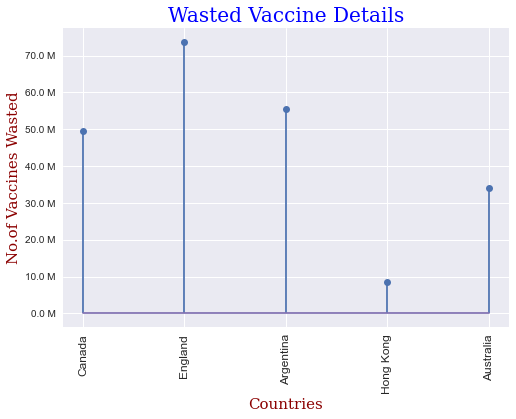

In [8]:
input_country = ['Canada','England','Argentina','Australia','Hong Kong']

vaccine_wasted_list =[list(i.values()) for i in col.aggregate([
    {'$match' : {'country' : {'$in' : input_country}}},
    {'$group':{'_id': "$country",'m1' : {'$max':'$total_vaccinations'}, 'm2' :{'$max':'$people_vaccinated'}}}])]

vaccine_wasted = list(map(lambda x:abs(x[2] - x[1]), vaccine_wasted_list))
countries = list(map(lambda x:x[0], vaccine_wasted_list))

fig, ax = plt.subplots(1,1) 
ax.yaxis.set_major_formatter(million_formatter)
ax.stem( countries,vaccine_wasted, use_line_collection = True)
ax.set_xticklabels(countries, rotation='vertical', fontsize=12)


plt.title("Wasted Vaccine Details", fontdict = font1)
plt.xlabel("Countries", fontdict = font2)
plt.ylabel("No.of Vaccines Wasted", fontdict = font2)